# Customer Classification Project Based on Spending Behavior

## Project Overview
This project aims to classify customers based on their financial behavior and goals derived from their spending and saving patterns. This classification enables businesses to better understand customer profiles and tailor financial products, services, or marketing strategies accordingly.

Two main labeling categories are used:

- **Financial Behavior Types (Behavior_Type):**
  - Disciplined (`disciplined`)
  - Volatile (`volatile`)
  - Spender (`spender`)
  - Unclassified (`unclassified`)

- **Financial Goals (Financial_Goal):**
  - Saver (`Saver`)
  - Investor (`Investor`)
  - Spender (`Spender`)

## Dataset Description

The dataset contains the following columns:

| Column Name         | Description                                         |
|---------------------|-----------------------------------------------------|
| Customer_ID         | Unique identifier for each customer                  |
| Savings_Rate        | The rate at which the customer saves money           |
| Investment_Rate     | The rate at which the customer invests money         |
| Debt_Ratio          | Ratio of customer's debt to income                    |
| Spending_Volatility | Volatility in the customer's spending behavior       |
| Spending_Rate       | The rate of spending                                   |
| Total_Spending      | Total amount spent by the customer                     |
| Behavior_Type       | Customer’s classified financial behavior (label)     |
| Financial_Goal      | Customer’s financial goal (label)                      |

---

## Labels Explanation

### Financial Behavior Types

| Label        | Description                                               |
|--------------|-----------------------------------------------------------|
| Disciplined  | Customers with consistent, planned spending and saving habits |
| Volatile     | Customers with irregular and unpredictable spending behavior |
| Spender      | Customers who spend freely, possibly overspending           |
| Unclassified | Customers who do not clearly fit into other categories       |

### Financial Goals

| Label    | Description                               |
|----------|-------------------------------------------|
| Saver    | Customers focused on saving money         |
| Investor | Customers who actively invest funds       |
| Spender  | Customers whose primary goal is spending  |

---

## Sample Data Preview

| Customer_ID | Savings_Rate | Investment_Rate | Debt_Ratio | Spending_Volatility | Spending_Rate | Total_Spending | Behavior_Type | Financial_Goal |
|-------------|--------------|-----------------|------------|---------------------|---------------|----------------|---------------|----------------|
| CUST1000    | 0            | 0.15            | 0.0816     | 1127.96             | 0.8856        | 13018.93       | unclassified  | Investor       |
| CUST1001    | 0.05         | 0.15            | 0.1058     | 598.62              | 0.9213        | 10444.70       | unclassified  | Investor       |
| CUST1002    | 0            | 0               | 0          | 2371.20             | 0.7497        | 10252.99       | volatile      | Spender        |
| CUST1010    | 0            | 0               | 0.1487     | 282.00              | 0.9520        | 7680.78        | spender       | Spender        |
| CUST1014    | 0.3          | 0.1             | 0.1307     | 761.74              | 0.9097        | 16010.30       | disciplined   | Investor       |

---

## Methodology

1. **Data Collection & Cleaning**
   - Load the dataset.
   - Handle missing or inconsistent values.
   - Remove irrelevant columns (e.g., Customer_ID if not used as a feature).

2. **Feature Engineering**
   - Create or transform features such as `Savings_Rate`, `Investment_Rate`, `Debt_Ratio`, `Spending_Volatility`, etc.
   - Normalize or scale numerical features if necessary.

3. **Label Encoding**
   - Convert categorical labels (`Behavior_Type`, `Financial_Goal`) to numeric labels for model training.

4. **Model Selection**
   - Select classification algorithms such as Random Forest, Logistic Regression, or Gradient Boosting.

5. **Training and Evaluation**
   - Split dataset into training and testing sets.
   - Train the model using the training set.
   - Evaluate model performance using metrics like accuracy, precision, recall, and F1-score.

6. **Prediction & Deployment**
   - Use the trained model to classify new customers.
   - Integrate the classification system into the business workflow.

---


In [21]:
# Install required libraries
!pip install -q pandas scikit-learn matplotlib seaborn xgboost lightgbm imbalanced-learn joblib shap

In [22]:
# Import Libraries

# Basic libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data preprocessing and splitting
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Classification models - Basic
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Classification models - Advanced
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Handling imbalance
from imblearn.over_sampling import SMOTE

# Evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP for model interpretation
import shap

# Model persistence
import joblib

In [23]:
# Load Data
df = pd.read_csv("customer_classification_data.csv")

In [24]:
# Clean Data

# Standardize text labels (lowercase) if columns exist
for col in ['Behavior_Type', 'Financial_Goal']:
    if col in df.columns:
        df[col] = df[col].str.lower()

# Drop Customer_ID if it exists
if 'Customer_ID' in df.columns:
    df.drop(columns=['Customer_ID'], inplace=True)

# Handle missing values if any
if df.isnull().sum().sum() > 0:
    df.fillna(method='ffill', inplace=True)

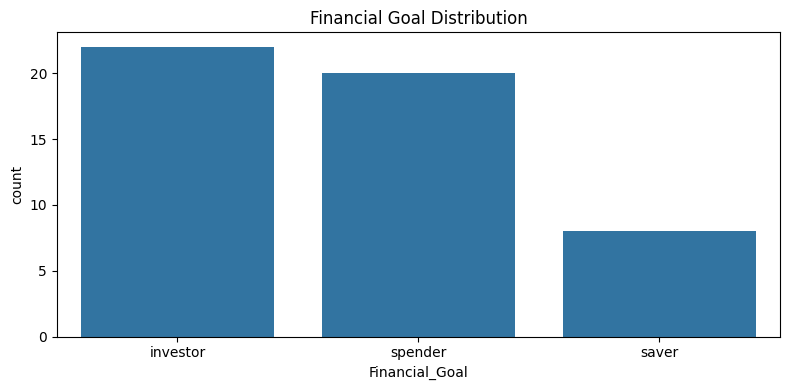

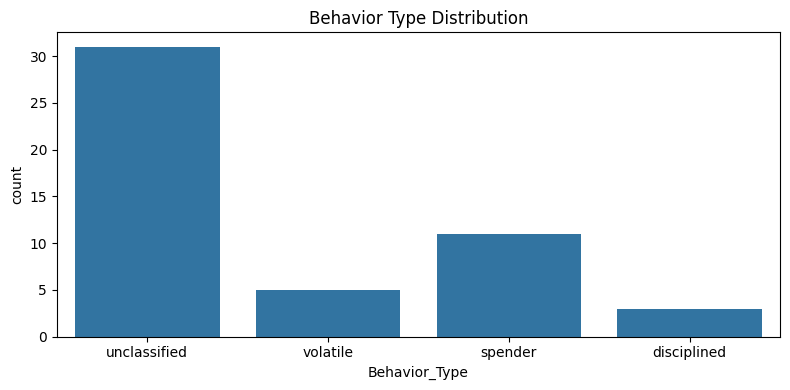

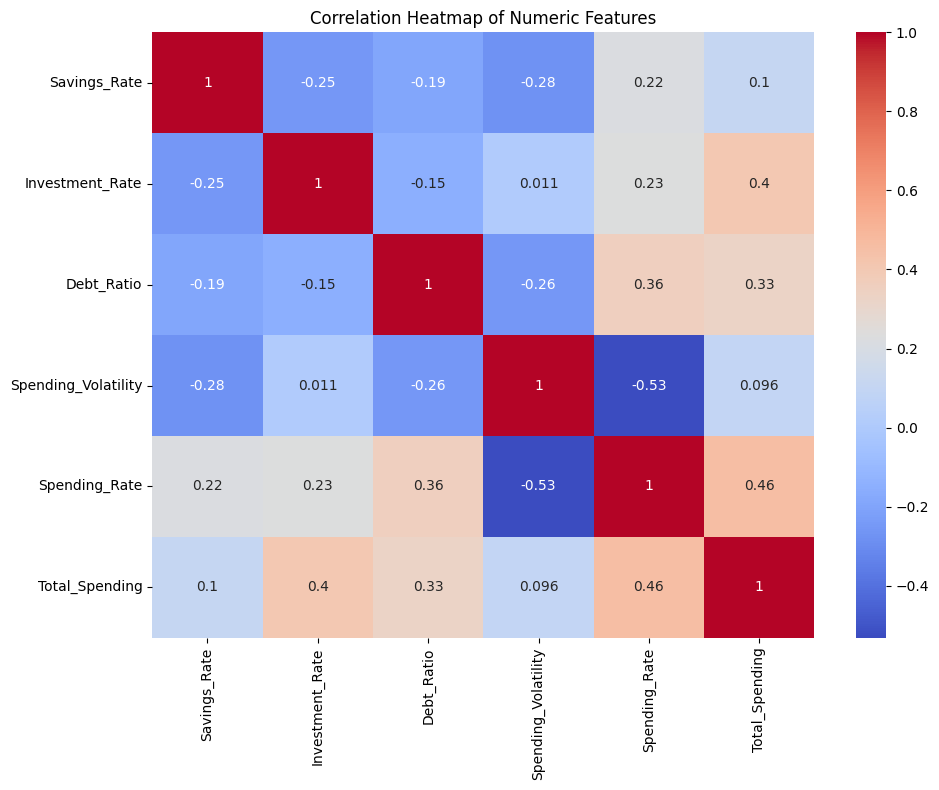

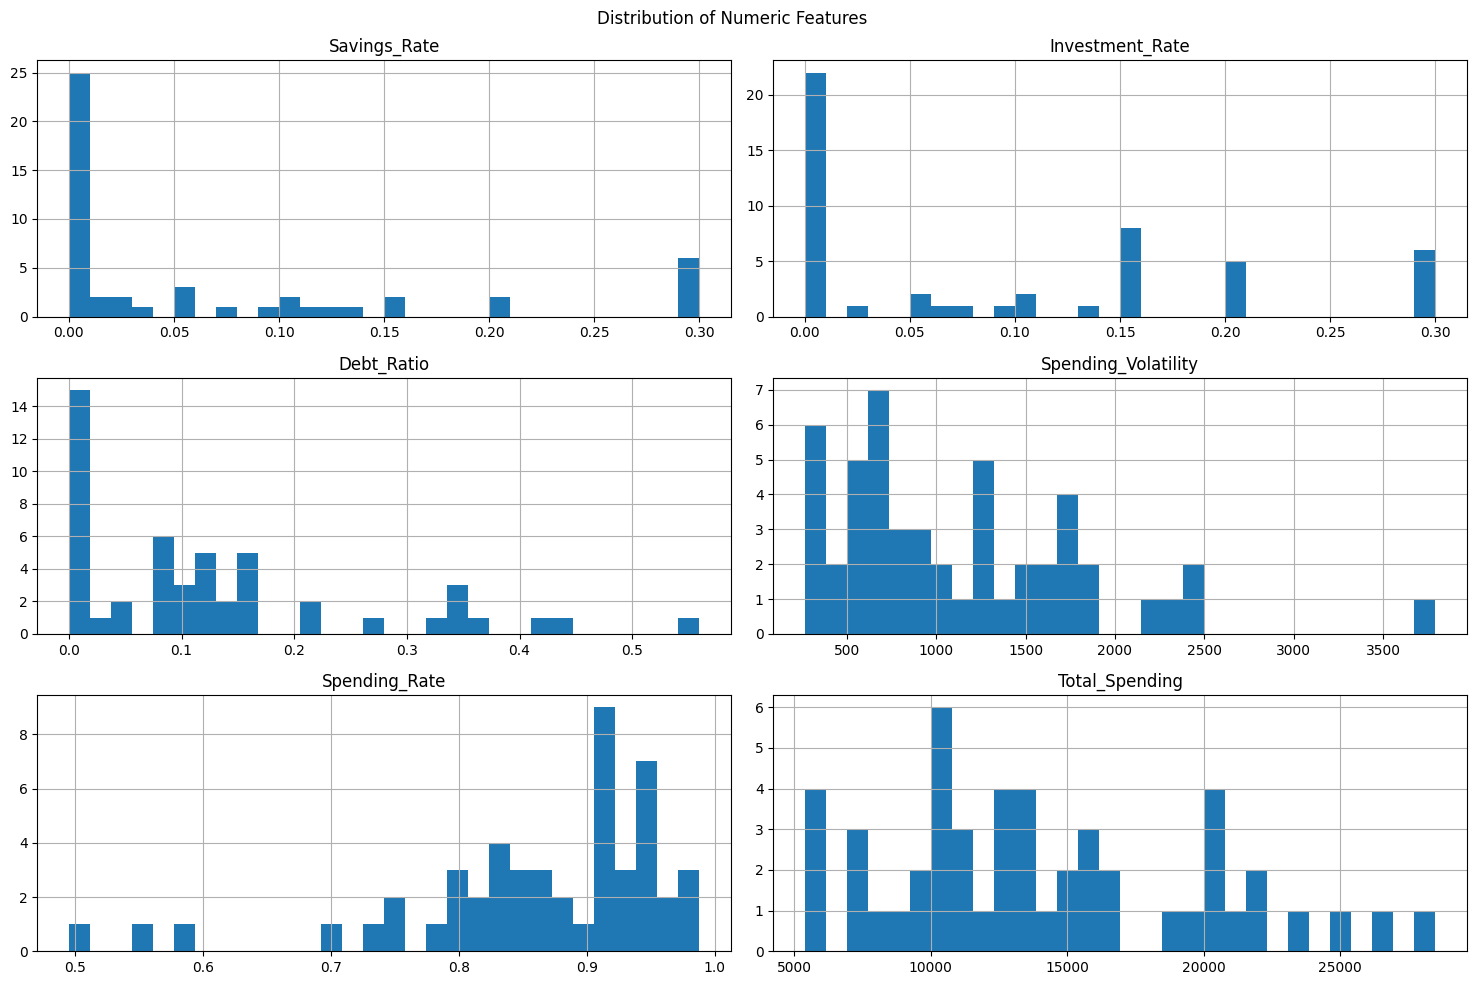

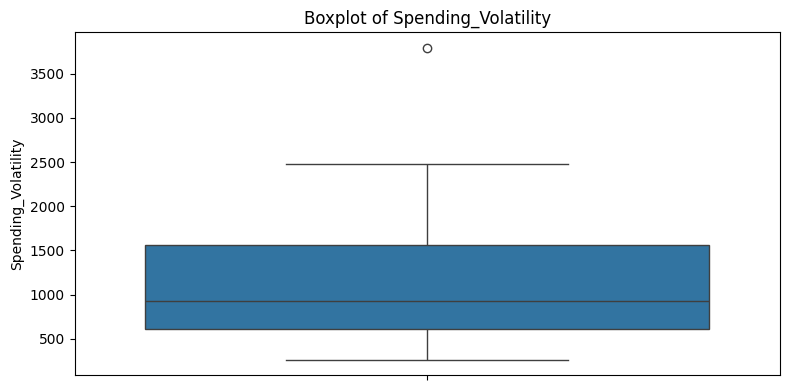

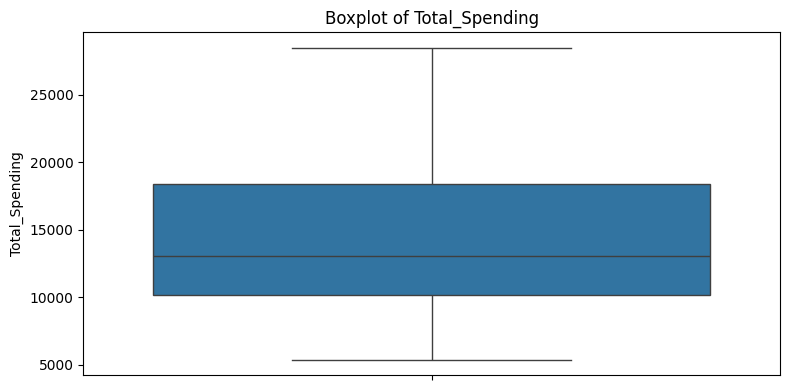

In [25]:
# Exploratory Data Analysis (EDA)

# Distribution of Financial Goals
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Financial_Goal')
plt.title("Financial Goal Distribution")
plt.tight_layout()
plt.show()

# Distribution of Behavior Types
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Behavior_Type')
plt.title("Behavior Type Distribution")
plt.tight_layout()
plt.show()

# Correlation heatmap of numeric features
feature_cols_basic = ['Savings_Rate', 'Investment_Rate', 'Debt_Ratio',
                      'Spending_Volatility', 'Spending_Rate', 'Total_Spending']

plt.figure(figsize=(10,8))
corr = df[feature_cols_basic].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

# Distribution of numeric features
df[feature_cols_basic].hist(bins=30, figsize=(15,10))
plt.suptitle("Distribution of Numeric Features")
plt.tight_layout()
plt.show()

# Boxplots for outlier detection
for feature in ['Spending_Volatility', 'Total_Spending']:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, y=feature)
    plt.title(f"Boxplot of {feature}")
    plt.tight_layout()
    plt.show()

In [26]:
# Handle Outliers
# Apply logarithmic transformation to variables with high value variance
df['Spending_Volatility_Log'] = np.log1p(df['Spending_Volatility'])
df['Total_Spending_Log'] = np.log1p(df['Total_Spending'])

# Use the log-transformed features to detect outliers
for feature in ['Spending_Volatility_Log', 'Total_Spending_Log']:
    mean = df[feature].mean()
    std = df[feature].std()
    upper_limit = mean + 3*std
    lower_limit = mean - 3*std

    # Instead of removing outliers, just warn and check how many rows are outside the limits
    outliers = df[(df[feature] < lower_limit) | (df[feature] > upper_limit)]
    print(f"Outliers detected in {feature}: {len(outliers)} rows")

    # Keep all data (no removal) because log transform reduces the impact of outliers

# Use the log-transformed columns instead of the original ones later in analysis and modeling

Outliers detected in Spending_Volatility_Log: 0 rows
Outliers detected in Total_Spending_Log: 0 rows


In [27]:
# Encode Categorical Columns

label_encoders = {}

for col in ["Behavior_Type", "Financial_Goal"]:
    le = LabelEncoder()
    df[col + "_Encoded"] = le.fit_transform(df[col])
    label_encoders[col] = le

In [28]:
# Select Features and Target

feature_cols = ['Savings_Rate', 'Investment_Rate', 'Debt_Ratio',
                'Spending_Volatility_Log', 'Spending_Rate', 'Total_Spending_Log',
                'Behavior_Type_Encoded']

X = df[feature_cols]
y = df['Financial_Goal_Encoded']

# Split Data into Train and Test Sets FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale Features AFTER splitting
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# Balance classes in training set using SMOTE to generate synthetic samples for minority classes
min_class_size = pd.Series(y_train).value_counts().min()
k_neighbors = max(1, min(min_class_size - 1, 5))

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE class distribution:\n", pd.Series(y_train).value_counts())
print("After SMOTE class distribution:\n", pd.Series(y_train_res).value_counts())

Before SMOTE class distribution:
 Financial_Goal_Encoded
0    18
2    16
1     6
Name: count, dtype: int64
After SMOTE class distribution:
 Financial_Goal_Encoded
0    18
2    18
1    18
Name: count, dtype: int64


In [30]:
# Define Classification Models

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),  # baseline linear model
    "Decision Tree": DecisionTreeClassifier(),                # simple tree model
    "Random Forest": RandomForestClassifier(random_state=42), # ensemble of trees
    "K-Nearest Neighbors": KNeighborsClassifier(),            # instance-based model
    "Support Vector Machine": SVC(probability=True, random_state=42), # max-margin classifier with probabilities
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), # gradient boosting
    "LightGBM": LGBMClassifier(random_state=42)               # faster gradient boosting
}

In [31]:
# Hyperparameter Tuning for Random Forest

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

print("Best Random Forest params:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
best_rf = grid_search.best_estimator_

# Replace Random Forest model with tuned one
models["Random Forest"] = best_rf

Best Random Forest params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation accuracy: 0.9074


In [45]:
# Train and Evaluate Models

results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{'='*40}")
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoders['Financial_Goal'].classes_))
    results[name] = (model, acc)


Model: Logistic Regression
Accuracy: 1.0000
              precision    recall  f1-score   support

    investor       1.00      1.00      1.00         4
       saver       1.00      1.00      1.00         2
     spender       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


Model: Decision Tree
Accuracy: 1.0000
              precision    recall  f1-score   support

    investor       1.00      1.00      1.00         4
       saver       1.00      1.00      1.00         2
     spender       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


Model: Random Forest
Accuracy: 1.0000
              precision    recall  f1-score   support

    investor       1.00      1.00      1.00         4
      

In [46]:
# Sort models by accuracy (desc)
sorted_results = sorted(results.items(), key=lambda x: x[1][1], reverse=True)

# Pick the top one
best_model_name, (best_model, best_accuracy) = sorted_results[0]

print(f"\n✅ Best Model: {best_model_name}")
print(f"🔢 Accuracy: {best_accuracy:.4f}")


✅ Best Model: Logistic Regression
🔢 Accuracy: 1.0000


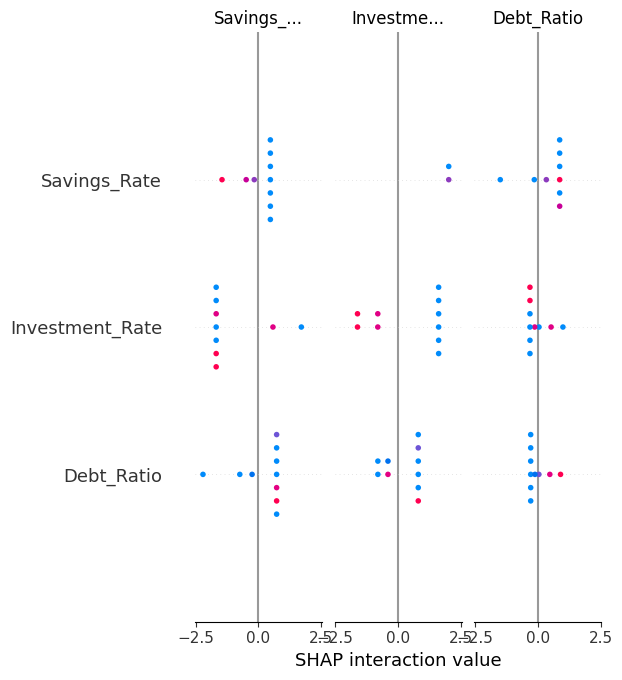

In [49]:
# Create an explainer using the best tree-based model

explainer = shap.LinearExplainer(best_model, X_train_scaled, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_cols)

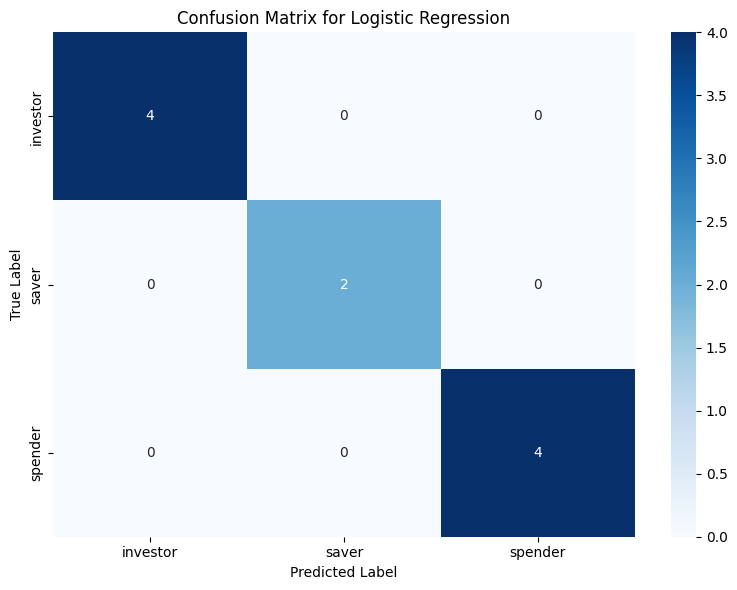

In [50]:
# Confusion Matrix for Best Model

# Predict using the best model
y_pred_best = best_model.predict(X_test_scaled)


# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Get class labels from the label encoder
labels = label_encoders['Financial_Goal'].classes_

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add title and axis labels
plt.title(f"Confusion Matrix for {best_model_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [51]:
# Scale all features before cross-validation
scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)

# Perform 5-fold cross-validation on the scaled features
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='accuracy')

# Print individual accuracy scores for each fold
print("Cross-validation accuracy scores:", cv_scores)

# Print mean and standard deviation of accuracy
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation accuracy scores: [0.9 0.9 0.9 0.8 0.8]
Mean CV accuracy: 0.8600 ± 0.0490


In [37]:
# Save the best trained model
joblib.dump(best_model, "best_financial_goal_model.pkl")

# Save the scaler used for feature normalization
joblib.dump(scaler, "scaler.pkl")

# Save the label encoders used for categorical encoding
joblib.dump(label_encoders, "label_encoders.pkl")

# Save the list of selected feature columns
joblib.dump(feature_cols, "feature_columns.pkl")

['feature_columns.pkl']

In [52]:
 # Prediction function for new customers
def predict_new_customer(new_data_dict):
    """
    Predicts the financial goal of a new customer based on their financial behavior.

    Parameters:
        new_data_dict (dict): A dictionary with the following keys:
            - "Savings_Rate"
            - "Investment_Rate"
            - "Debt_Ratio"
            - "Spending_Volatility"
            - "Spending_Rate"
            - "Total_Spending"
            - "Behavior_Type" (string)

    Returns:
        str: Predicted Financial Goal (decoded label)
    """

    # Load saved artifacts
    model = joblib.load("best_financial_goal_model.pkl")
    scaler = joblib.load("scaler.pkl")
    label_encoders = joblib.load("label_encoders.pkl")
    feature_cols = joblib.load("feature_columns.pkl")

    # Apply log transform to Spending_Volatility and Total_Spending (same كما في التدريب)
    spending_volatility_log = np.log1p(new_data_dict["Spending_Volatility"])
    total_spending_log = np.log1p(new_data_dict["Total_Spending"])

    # Encode the categorical feature
    behavior_encoded = label_encoders["Behavior_Type"].transform([new_data_dict["Behavior_Type"].lower()])[0]

    # Construct input array using the log-transformed features
    input_list = [
        new_data_dict["Savings_Rate"],
        new_data_dict["Investment_Rate"],
        new_data_dict["Debt_Ratio"],
        spending_volatility_log,
        new_data_dict["Spending_Rate"],
        total_spending_log,
        behavior_encoded
    ]
    input_array = np.array(input_list).reshape(1, -1)
    input_scaled = scaler.transform(input_array)

    # Make prediction
    pred_encoded = model.predict(input_scaled)[0]
    pred_label = label_encoders["Financial_Goal"].inverse_transform([pred_encoded])[0]

    return pred_label

In [39]:
# Example Prediction for a New Customer

new_customer_example = {
    "Savings_Rate": 0.05,
    "Investment_Rate": 0.10,
    "Debt_Ratio": 0.12,
    "Spending_Volatility": 1100,
    "Spending_Rate": 0.7,
    "Total_Spending": 11500,
    "Behavior_Type": "volatile"
}

print("Predicted financial goal for new customer:", predict_new_customer(new_customer_example))

Predicted financial goal for new customer: investor


## 🧩 Interactive Dashboard

This section provides an interactive dashboard built using **Gradio**, allowing users to explore the customer classification model in real time.

### 🎯 Purpose:
To provide an intuitive interface for testing and visualizing predictions from the trained classification model.

### ⚙️ Features:
- Upload or enter customer financial data (e.g., spending, income, volatility).
- Get instant predictions of customer behavior type: **Spender**, **Saver**, or **Investor**.
- Display prediction probabilities for better insight and confidence evaluation.
- Simple and user-friendly interface suitable for both technical and non-technical users.

### 💡 Business Use Cases:
- Enables financial teams or customer service representatives to assess customer profiles on the fly.
- Supports personalized recommendations, product targeting, or credit risk decisions based on predicted behavior type.

### 📍 Note:
The dashboard is embedded below and can also be deployed as a standalone web app.


In [40]:
!pip install gradio -q

In [53]:
import gradio as gr
import joblib
import numpy as np

# Load the saved model, scaler, label encoders, and feature columns
model = joblib.load("best_financial_goal_model.pkl")
scaler = joblib.load("scaler.pkl")
label_encoders = joblib.load("label_encoders.pkl")
feature_cols = joblib.load("feature_columns.pkl")

def predict_new_customer_gradio(
    Savings_Rate,
    Investment_Rate,
    Debt_Ratio,
    Spending_Volatility,
    Spending_Rate,
    Total_Spending,
    Behavior_Type
):
    """
    Receives customer financial data and predicts the financial goal.
    """
    # Apply log transform to Spending_Volatility and Total_Spending as done in training
    spending_volatility_log = np.log1p(Spending_Volatility)
    total_spending_log = np.log1p(Total_Spending)

    # Encode behavior type using the label encoder (convert to lowercase first)
    behavior_encoded = label_encoders["Behavior_Type"].transform([Behavior_Type.lower()])[0]

    # Prepare input array matching training features order
    input_list = [
        Savings_Rate,
        Investment_Rate,
        Debt_Ratio,
        spending_volatility_log,
        Spending_Rate,
        total_spending_log,
        behavior_encoded
    ]

    # Convert to numpy array and scale
    input_array = np.array(input_list).reshape(1, -1)
    input_scaled = scaler.transform(input_array)

    # Predict encoded class and decode to original label
    pred_encoded = model.predict(input_scaled)[0]
    pred_label = label_encoders["Financial_Goal"].inverse_transform([pred_encoded])[0]

    return f"Predicted Financial Goal: {pred_label}"

# Define behavior types exactly as per your data
behavior_options = ["disciplined", "volatile", "spender", "unclassified"]

# Gradio Interface Setup
interface = gr.Interface(
    fn=predict_new_customer_gradio,
    inputs=[
        gr.Number(label="Savings Rate (e.g., 0.05)"),
        gr.Number(label="Investment Rate (e.g., 0.1)"),
        gr.Number(label="Debt Ratio (e.g., 0.2)"),
        gr.Number(label="Spending Volatility (e.g., 1100)"),
        gr.Number(label="Spending Rate (e.g., 0.75)"),
        gr.Number(label="Total Spending (e.g., 12000)"),
        gr.Radio(behavior_options, label="Behavior Type")
    ],
    outputs=gr.Textbox(label="Predicted Financial Goal"),
    title="Customer Financial Goal Prediction",
    description="Input customer financial behavior data to predict their financial goal."
)

# Launch the dashboard
interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a56bd049ceafd387a3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Recommendations & Real-World Applications

- **Targeted Marketing Campaigns:** Design personalized marketing strategies tailored to customers’ predicted financial goals, increasing engagement and conversion rates.
- **Product Offering Alignment:** Offer specialized financial products such as investment plans for ‘Investors’ and savings accounts or deposit schemes for ‘Savers’ to meet their unique needs.
- **Financial Counseling & Risk Management:** Provide targeted financial education and counseling to ‘Spenders’ to promote healthier spending habits and reduce financial risk.
- **Credit and Loan Personalization:** Use classification insights to customize credit limits, loan offers, and interest rates, minimizing defaults and optimizing lending strategies.
- **Customer Retention & Loyalty:** Leverage behavioral predictions to create loyalty programs and retention strategies that resonate with different customer segments.